# Натянуть сову на линейное пространство

Создайте эмбеддинги слов и визуализируйте векторные операции над ними: сложение, вычитание, взятие ближайшего, дальнейшего и прочее. Сравните качество представлений gensim и BERT с точки зрения операций над словами, докажите примерами.

Для создания эмбеддингов с gensim обучите модель на нормализованных текстовых данных. Данные найдите на kaggle или выберите один из предложенных датасетов. Для создания эмбеддингов с BERT используйте предобученные модели.

Предлагаемые датасеты:
 - [sentiment твитов про ковид](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)
 - [Amazon product reviews](https://www.kaggle.com/kashnitsky/hierarchical-text-classification)
 - [Отзывы интернет-магазина](https://www.kaggle.com/shymammoth/shopee-reviews)
 - [Тексты статей конференции NIPS](https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

In [2]:
df = pd.read_csv('shopee_reviews.csv')
df.drop('label', axis=1, inplace=True)
df = df[:300000]
print(df.shape)
df.head()

(300000, 1)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,text
0,Looks ok. Not like so durable. Will hv to use ...
1,"Tried, the current can be very powerful depend..."
2,Item received after a week. Looks smaller than...
3,Thanks!!! Works as describe no complaints. Not...
4,Fast delivery considering it’s from overseas a...


In [3]:
from itertools import chain
from typing import List
from collections import Counter

def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab
texts = df.text.tolist()
vocab = build_vocab(texts)
print(len(vocab))
# слова разного регистра
list(vocab.items())[:10]

116907


[('Looks', 4753),
 ('ok.', 2943),
 ('Not', 5938),
 ('like', 12649),
 ('so', 19439),
 ('durable.', 256),
 ('Will', 16777),
 ('hv', 242),
 ('to', 89874),
 ('use', 8019)]

In [4]:
# удалим спецсимволы

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    return text

texts = [preprocess_text(text) for text in df.text.tolist()]
vocab = build_vocab(texts)
print(len(vocab))
# уже лучше. Но кажется есть очень частые слова
list(vocab.items())[:10]

53672


[('looks', 13884),
 ('ok', 9990),
 ('not', 31955),
 ('like', 14047),
 ('so', 23191),
 ('durable', 730),
 ('will', 33252),
 ('hv', 300),
 ('to', 90314),
 ('use', 11612)]

In [5]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

eng_stopwords = stopwords.words('english')
print(len(eng_stopwords))
eng_stopwords[:5]

179


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milenabulkina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

In [6]:
eng_stopwords = stopwords.words('english')
is_stopword = lambda word: word not in eng_stopwords

# Исключаем бессмысленные для анализа слова
def preprocess_text(text: str) -> str:
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    is_stopword = lambda word: word not in eng_stopwords
    text = text.lower()
    text = ''.join(list(filter(is_allowed_char, text)))
    text = ' '.join(list(filter(is_stopword, text.split())))
    return text


texts = [preprocess_text(text) for text in df.text.tolist()]
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(30)

53532


[('good', 125569),
 ('delivery', 80684),
 ('received', 79618),
 ('fast', 68127),
 ('item', 50871),
 ('seller', 44332),
 ('condition', 41743),
 ('quality', 40389),
 ('well', 38388),
 ('nice', 26370),
 ('thank', 26114),
 ('buy', 26075),
 ('product', 23053),
 ('thanks', 21629),
 ('price', 21115),
 ('purchase', 20767),
 ('order', 19492),
 ('items', 18740),
 ('came', 17376),
 ('time', 17147),
 ('love', 16479),
 ('great', 14773),
 ('material', 14389),
 ('like', 14047),
 ('looks', 13884),
 ('really', 13652),
 ('quite', 13327),
 ('size', 13102),
 ('yet', 13046),
 ('packed', 12851)]

In [7]:
# похожие слова

sorted(vocab.keys())[7020:7050]

['cif',
 'cig',
 'cigarette',
 'cigarettes',
 'cimilre',
 'cinabons',
 'cinch',
 'cinches',
 'cindition',
 'cindy',
 'cinema',
 'cinematic',
 'cinna',
 'cinnabar',
 'cinnamon',
 'cinnamoroll',
 'cinvenientfast',
 'cip',
 'circle',
 'circled',
 'circles',
 'circuit',
 'circuitbreaker',
 'circuits',
 'circular',
 'circulate',
 'circulation',
 'circulator',
 'circumference',
 'circumferencestill']

In [8]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

In [9]:
for word in sorted(vocab.keys())[7020:7050]:
    print('%15s %s' % (word, stemmer.stem(word)))

            cif cif
            cig cig
      cigarette cigarett
     cigarettes cigarett
        cimilre cimilr
       cinabons cinabon
          cinch cinch
        cinches cinch
      cindition cindit
          cindy cindi
         cinema cinema
      cinematic cinemat
          cinna cinna
       cinnabar cinnabar
       cinnamon cinnamon
    cinnamoroll cinnamorol
 cinvenientfast cinvenientfast
            cip cip
         circle circl
        circled circl
        circles circl
        circuit circuit
 circuitbreaker circuitbreak
       circuits circuit
       circular circular
      circulate circul
    circulation circul
     circulator circul
  circumference circumfer
circumferencestill circumferencestil


In [10]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/milenabulkina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
for word in sorted(vocab.keys())[7020:7050]:
    print('%15s %s' % (word, lemmatizer.lemmatize(word)))

            cif cif
            cig cig
      cigarette cigarette
     cigarettes cigarette
        cimilre cimilre
       cinabons cinabons
          cinch cinch
        cinches cinch
      cindition cindition
          cindy cindy
         cinema cinema
      cinematic cinematic
          cinna cinna
       cinnabar cinnabar
       cinnamon cinnamon
    cinnamoroll cinnamoroll
 cinvenientfast cinvenientfast
            cip cip
         circle circle
        circled circled
        circles circle
        circuit circuit
 circuitbreaker circuitbreaker
       circuits circuit
       circular circular
      circulate circulate
    circulation circulation
     circulator circulator
  circumference circumference
circumferencestill circumferencestill


In [14]:
from tqdm import tqdm
def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    is_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))
    
    text = ' '.join(list(map(stemmer.stem, text.split())))
    return text


texts = []
for text in tqdm(df.text.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(30)

100%|█████████████████████████████████| 300000/300000 [01:18<00:00, 3829.13it/s]


44387


[('good', 126966),
 ('receiv', 85162),
 ('deliveri', 80755),
 ('item', 69616),
 ('fast', 68147),
 ('thank', 47947),
 ('seller', 45170),
 ('condit', 42959),
 ('qualiti', 40427),
 ('well', 38419),
 ('nice', 34411),
 ('order', 31308),
 ('buy', 30764),
 ('product', 26156),
 ('purchas', 24002),
 ('price', 22223),
 ('love', 21970),
 ('look', 20657),
 ('time', 19519),
 ('use', 19515),
 ('work', 18719),
 ('tri', 17933),
 ('came', 17379),
 ('recommend', 17099),
 ('pack', 16945),
 ('like', 15906),
 ('day', 15250),
 ('materi', 14941),
 ('size', 14866),
 ('great', 14780)]

In [15]:
reviews = df['text']

In [16]:
drop_not_letters = lambda s: ''.join(list(filter(lambda c: c.isalpha() or c == ' ', s)))

reviews = [drop_not_letters(review.lower()) for review in reviews]

reviews = [' '.join(list(map(stemmer.stem, review.split()))) for review in reviews]

reviews[0:10]

['look ok not like so durabl will hv to use a while to recommend other of it worth',
 'tri the current can be veri power depend on the set i dont dare to go higher but if go higher sure muscl will becom sore and can see the effect faster',
 'item receiv after a week look smaller than expect cant wait to tri',
 'thank work as describ no complaint not realli expect ani life chang result but thank',
 'fast deliveri consid it from oversea and onli tri onc not sure about the result yet',
 'fast deliveri good servic',
 'got my order and it came well packag have yet to tri but look good so far thank',
 'item receiv in a nice box have not use it yet hope it work',
 'receiv in good condit tri so far so good not that bad',
 'item doesnt work ask me to send a refund show a non work machin and deem not enough evid dont wast time buy']

In [17]:
from gensim.models import Word2Vec

sentences = [review.split() for review in reviews]
gensim_model = Word2Vec(sentences=sentences,
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=15, 
                 min_count=1
                 )
print('размерность векторов слов в модели:', gensim_model.wv.vectors.shape)

размерность векторов слов в модели: (44461, 100)


In [18]:
# Спроецируем в 2d пространство
import umap.umap_ as umap

points = umap.UMAP(n_neighbors = 10, min_dist = 0.2, random_state = 42).fit_transform(gensim_model.wv.vectors[:500])

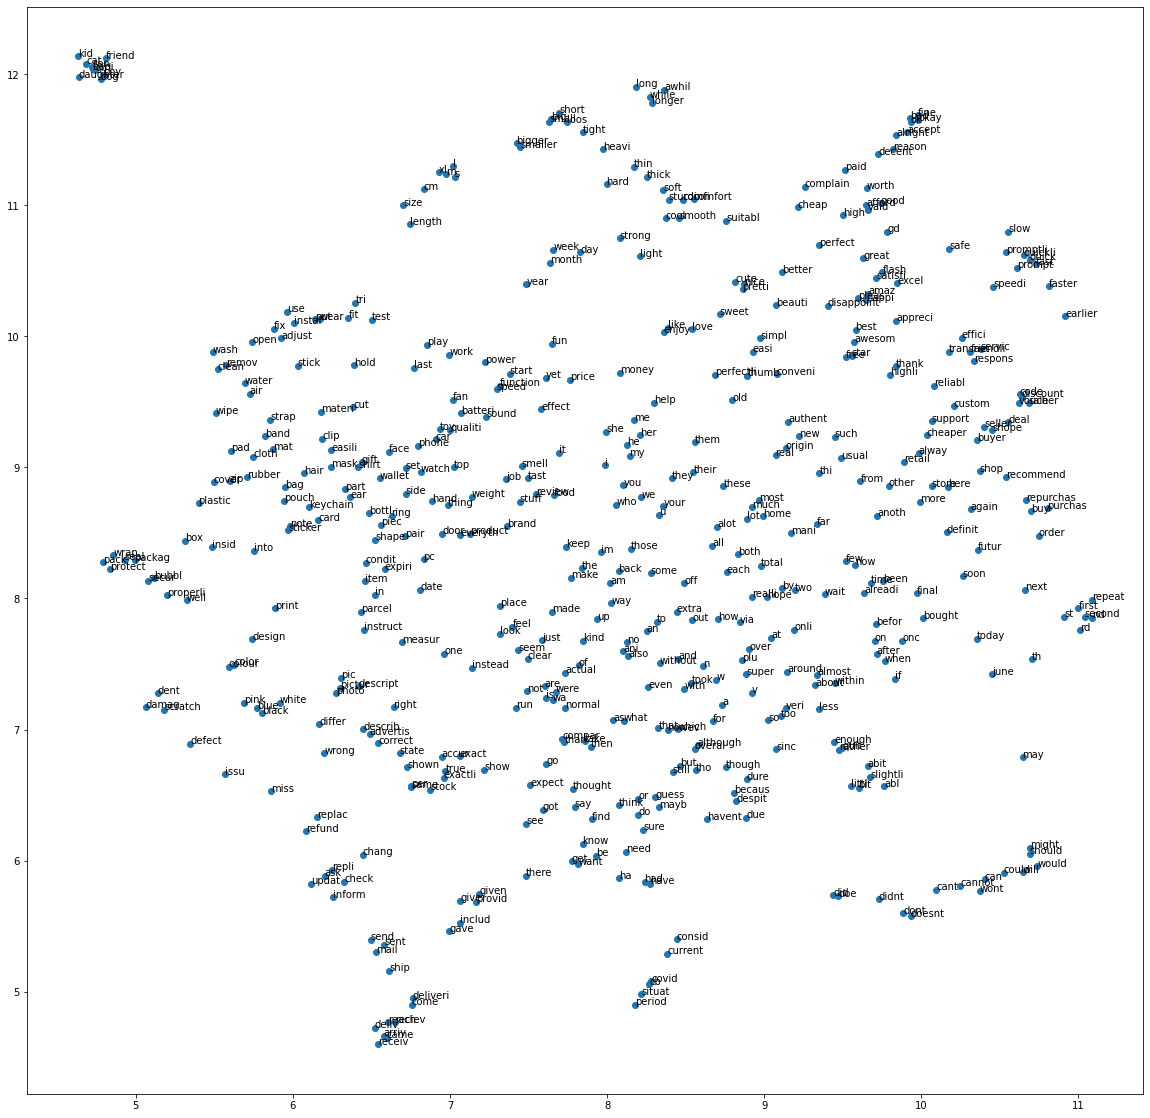

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(gensim_model.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [20]:
gensim_model.wv.most_similar('awesom')

[('fantast', 0.7381964921951294),
 ('amaz', 0.725100576877594),
 ('great', 0.7213115096092224),
 ('excel', 0.6724184155464172),
 ('superb', 0.666268527507782),
 ('marvel', 0.5031813383102417),
 ('gorgeou', 0.4962315261363983),
 ('goodth', 0.49101701378822327),
 ('stun', 0.49071094393730164),
 ('outstand', 0.4790186583995819)]

In [35]:
def add(v1, v2):
    ans = []
    for i in range (0, len(v1)):
        ans.append(v1[i] + v2[i])
    return np.array(ans)

def sub(v1, v2):
    ans = []
    for i in range (0, len(v1)):
        ans.append(v1[i] - v2[i])
    return np.array(ans)

In [36]:
gensim_model.wv.most_similar(sub(add(gensim_model.wv['sister'], gensim_model.wv['man']), gensim_model.wv['woman']))

[('man', 0.8054928183555603),
 ('sister', 0.6901760101318359),
 ('helper', 0.6589937210083008),
 ('cousin', 0.6571877598762512),
 ('bro', 0.6560074687004089),
 ('partner', 0.6530446410179138),
 ('si', 0.6494281888008118),
 ('dad', 0.6472043395042419),
 ('guy', 0.643832802772522),
 ('husband', 0.638888955116272)]

In [23]:
from transformers import BertTokenizer, BertModel
import torch

model_bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def make_word_embedding(text: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens]).detach()
    segments_tensors = torch.tensor([segments_ids]).detach()
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    last_layer_embs = outputs[2][-1]
    word_embedding = last_layer_embs.squeeze(0).sum(dim=0)
    
    return word_embedding

In [25]:
def bert_vec(name):
    return make_word_embedding(name).detach().numpy()

In [32]:
make_word_embedding('man').size()

torch.Size([768])

In [26]:
from scipy.spatial import distance

similarity = pd.DataFrame(list(vocab), columns=['word'])
vec = sub(add(bert_vec('sister'), bert_vec('man')), bert_vec('woman'))
similarity['dist'] = similarity['word'].apply(lambda w: distance.cosine(vec, bert_vec(w)))

In [27]:
similarity.sort_values(by = ['dist']).head(10)

,word,dist
1945,sister,0.365710
9645,ft,0.440347
5163,spoke,0.453064
446,man,0.461094
34664,himalayan,0.462809
17059,metk,0.469921
38821,dingli,0.470566
3123,mcg,0.473579
4176,goddess,0.474044
12223,mart,0.476812


# Projector

Из прошлого задания вы выяснили наиболее хорошую для представления связей между словами модель. Спроецируйте ~2-3 тысячи наиболее популярных слов из выбранного корпуса в tensorflow projector.

In [38]:
words = []

for w, i in vocab.most_common(2000):
    words.append(w)
    
texts_embs = []
for word in tqdm(words):
    emb = gensim_model.wv[word]
    texts_embs.append(emb)

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 250870.51it/s]


In [39]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()
writer.add_embedding(texts_embs, metadata = words)
writer.close()

In [40]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 42569), started 13:41:44 ago. (Use '!kill 42569' to kill it.)